<a href="https://colab.research.google.com/github/JuShiCode/JuShiCode/blob/main/%D0%A1%D0%B5%D0%B3%D0%BC%D0%B5%D0%BD%D1%82%D0%B0%D1%86%D0%B8%D1%8F_%D0%B8%D0%B7%D0%BE%D0%B1%D1%80%D0%B0%D0%B6%D0%B5%D0%BD%D0%B8%D0%B9_PSPNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Загрузка библиотек

In [ ]:
from tensorflow.keras.models import Model # Импортируем модели keras: Model
from tensorflow.keras.layers import Input, Conv2DTranspose, concatenate, Activation, MaxPooling2D, AveragePooling2D, UpSampling2D, Conv2D, BatchNormalization, LeakyReLU, Dropout # Импортируем стандартные слои keras
from tensorflow.keras import backend as K # Импортируем модуль backend keras'а
from tensorflow.keras.optimizers import Adam # Импортируем оптимизатор Adam
from tensorflow.keras import utils # Импортируем модуль utils библиотеки tensorflow.keras для получения OHE-представления
from google.colab import files # Импортируем Модуль files для работы с файлами
import matplotlib.pyplot as plt # Импортируем модуль pyplot библиотеки matplotlib для построения графиков
from tensorflow.keras.preprocessing import image # Импортируем модуль image для работы с изображениями
import numpy as np # Импортируем библиотеку numpy
from sklearn.model_selection import train_test_split
import time
import random
import os # Импортируем библиотеку os для раоты с фаловой системой
from PIL import Image # импортируем модель Image для работы с изображениями

#Загрузка данных

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# Глобальные параметры
img_width = 176  
img_height = 240 
num_classes = 7 
directory = '/content/drive/My Drive/Базы/Сегментация/' 
train_directory = 'Тренировочная_стройка' 
val_directory = 'Проверочная_стройка' 

In [6]:
train_images = [] # Создаем пустой список для хранения оригинальных изображений обучающей выборки
val_images = [] # Создаем пустой список для хранения оригинальных изображений проверочной выборки
test_images = [] # Создаем пустой список для хранения оригинальных изображений тестовой выборки

cur_time = time.time() # Засекаем текущее время
for filename in sorted(os.listdir(directory + train_directory+'/Исходники')): # Проходим по всем файлам в каталоге по указанному пути     
    train_images.append(image.load_img(os.path.join(directory + train_directory+'/Исходники',filename),
                                       target_size=(img_width, img_height))) # Читаем очередную картинку и добавляем ее в список изображения с указанным target_size                                                      
print ('Обучающая выборка загружена. Время загрузки: ', round(time.time() - cur_time, 2), 'c', sep='') # Отображаем время загрузки картинок обучающей выборки
print ('Количество изображений: ', len(train_images)) # Отображаем количество элементов в обучающей выборке

cur_time = time.time() # Засекаем текущее время
for filename in sorted(os.listdir(directory + val_directory+'/Исходники')): # Проходим по всем файлам в каталоге по указанному пути                  
    val_images.append(image.load_img(os.path.join(directory + val_directory+'/Исходники',filename), 
                                     target_size=(img_width, img_height)))  # Читаем очередную картинку и добавляем ее в список изображения с указанным target_size   
print ('Проверочная выборка загружена. Время загрузки: ', round(time.time() - cur_time, 2), 'c', sep='') # Отображаем время загрузки картинок проверочной выборки
print ('Количество изображений: ', len(val_images)) # Отображаем количество элементов в проверочной выборке

Обучающая выборка загружена. Время загрузки: 286.23c
Количество изображений:  900
Проверочная выборка загружена. Время загрузки: 15.49c
Количество изображений:  50


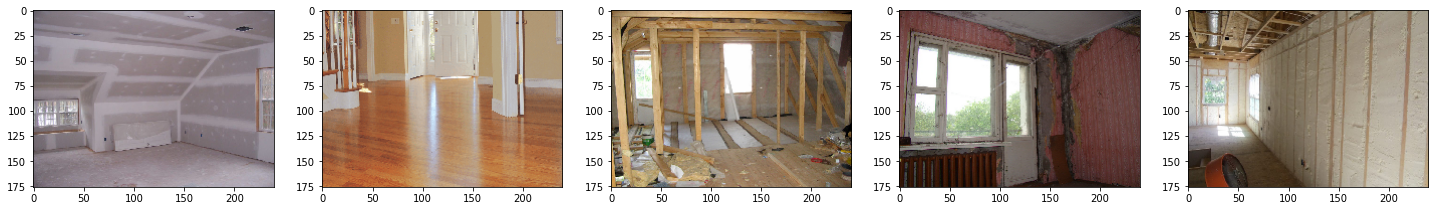

In [7]:
n = 5 # Количество выводимых случайных картинок
fig, axs = plt.subplots(1, n, figsize=(25, 5)) #Создаем полотно из n графиков
for i in range(n): # Выводим в цикле n случайных изображений
  img = random.choice(train_images) # Выбираем случайное фото для отображения
  axs[i].imshow(img) # Отображаем фото
plt.show() #Показываем изображения

In [9]:
train_segments = [] # Создаем пустой список для хранения оригинальных изображений обучающей выборки
val_segments = [] # Создаем пустой список для хранения оригинальных изображений проверочной выборки

cur_time = time.time() # Засекаем текущее время
for filename in sorted(os.listdir(directory + train_directory+'/Размеченные')): #Проходим по всем файлам в каталоге по указанному пути     
    train_segments.append(image.load_img(os.path.join(directory + train_directory+'/Размеченные',filename),
                                       target_size=(img_width, img_height))) # Читаем очередную картинку и добавляем ее в список изображения с указанным target_size                                                      
print ('Обучающая выборка загружена. Время загрузки: ', round(time.time() - cur_time, 2), 'c', sep='') # Отображаем время загрузки картинок обучающей выборки
print ('Количество изображений: ', len(train_segments)) # Отображаем количество элементов в обучающем наборе сегментированных изображений

cur_time = time.time() # Засекаем текущее время
# Проходим по всем файлам в каталоге по указанному пути 
for filename in sorted(os.listdir(directory + val_directory+'/Размеченные')):
    # Читаем очередную картинку и добавляем ее в список изображения с указанным target_size                                                      
    val_segments.append(image.load_img(os.path.join(directory + val_directory+'/Размеченные',filename), 
                                     target_size=(img_width, img_height)))  # Читаем очередную картинку и добавляем ее в список изображения с указанным target_size   
print ('Проверочная выборка загружена. Время загрузки: ', round(time.time() - cur_time, 2), 'c', sep='') # Отображаем время загрузки картинок проверочной выборки
print ('Количество изображений: ', len(val_segments)) # Отображаем количество элементов в проверочном наборе сегментированных изображений

Обучающая выборка загружена. Время загрузки: 197.21c
Количество изображений:  900
Проверочная выборка загружена. Время загрузки: 29.22c
Количество изображений:  50


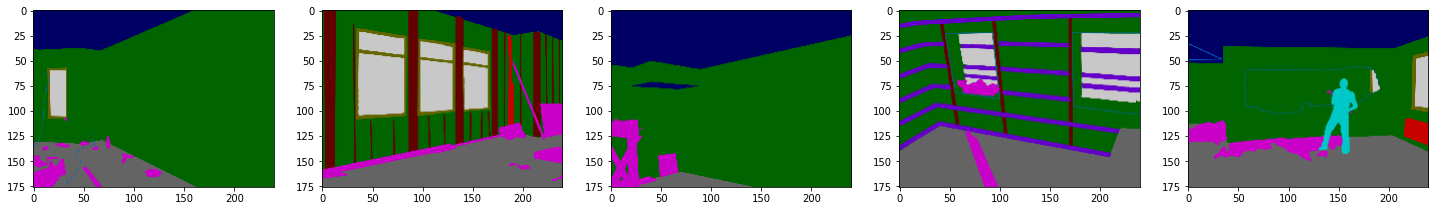

In [ ]:
n = 5 # Количество выводимых случайных картинок
fig, axs = plt.subplots(1, n, figsize=(25, 5)) #Создаем полотно из n графиков
for i in range(n): # Выводим в цикле n случайных изображений
  img = random.choice(train_segments) # Выбираем случайное фото для отображения
  axs[i].imshow(img) # Отображаем фото
plt.show() #Показываем изображения

#Формирование выборок

In [ ]:
xTrain = [] # Создаем пустой список под обучающую выборку
for img in train_images: # Проходим по всем изображениям из train_images
  x = image.img_to_array(img) # Переводим изображение в numpy-массив размерностью: высота - ширина - количество каналов
  xTrain.append(x) # Добавляем очередной элемент в xTrain
xTrain = np.array(xTrain) # Переводим в numpy

xVal = [] # Создаем пустой список под проверочную выборку
for img in val_images: # Проходим по всем изображениям из val_images
  x = image.img_to_array(img) # Переводим изображение в numpy-массив размерностью: высота - ширина - количество каналов
  xVal.append(x) # Добавляем очередной элемент в xTrain
xVal = np.array(xVal) # Переводим в numpy

print(xTrain.shape) # Размерность обучающей выборки
print(xVal.shape) # Размерность проверочной выборки

(900, 176, 240, 3)
(50, 176, 240, 3)


In [ ]:
cur_time = time.time() # Засекаем текущее время
yTrain = yt_prep(train_segments, num_classes)  # Создаем yTrain
print('Время обработки: ', round(time.time() - cur_time, 2),'c') # Выводим время работы

100
200
300
400
500
600
700
800
900
Время обработки:  1158.39 c


In [ ]:
cur_time = time.time() # Засекаем текущее время
yVal = yt_prep(val_segments, num_classes) # Создаем yVal
print('Время обработки: ', round(time.time() - cur_time, 2),'c') # Выводим время работы

Время обработки:  60.13 c


In [ ]:
xTrain = xTrain / 255
xVal = xVal / 255

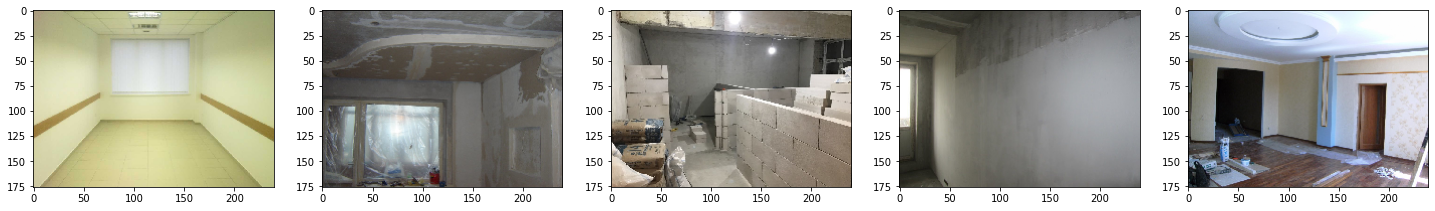

In [ ]:
n = 5 # Количество выводимых случайных картинок
fig, axs = plt.subplots(1, n, figsize=(25, 5)) #Создаем полотно из n графиков
for i in range(n): # Выводим в цикле n случайных изображений
  img = random.choice(xTrain) # Выбираем случайное фото для отображения
  axs[i].imshow(img) # Отображаем фото
plt.show() #Показываем изображения

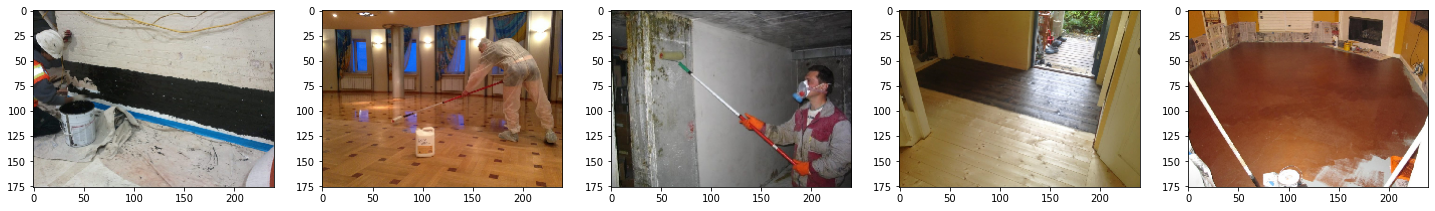

In [ ]:
n = 5 # Количество выводимых случайных картинок
fig, axs = plt.subplots(1, n, figsize=(25, 5)) #Создаем полотно из n графиков
for i in range(n): # Выводим в цикле n случайных изображений
  img = random.choice(xVal) # Выбираем случайное фото для отображения
  axs[i].imshow(img) # Отображаем фото
plt.show() #Показываем изображения

#Параметризация изображений

In [ ]:
# Функция преобразования пикселя сегментированного изображения в индекс (7 классов)
def color2index(color):
  index=-1
  if (149>=color[0]>51)and(149>=color[1]>=51)and(149>=color[2]>=51) : index=0 # пол
  elif (49>=color[0]>=0)and(49>=color[1]>=0)and(149>=color[2]>=51) : index=1 # потолок
  elif (49>=color[0]>=0)and(149>=color[1]>=51)and(49>=color[2]>=0) : index=2 # стена
  elif (149>=color[0]>=51)and(49>=color[1]>=0)and(49>=color[2]>=0) : index=4 # колонна
  elif (49>=color[0]>=0)and(149>=color[1]>=51)and(149>=color[2]>=51) : index=3 # проем
  elif (149>=color[0]>=51)and(49>=color[1]>=0)and(149>=color[2]>=51) : index=3 # дверь
  elif (149>=color[0]>=51)and(149>=color[1]>=51)and(49>=color[2]>=0) : index=3 # окно
  elif (249>=color[0]>=151)and(249>=color[1]>=151)and(249>=color[2]>=151) : index=4 # внешний мир
  elif (49>=color[0]>=0)and(49>=color[1]>=51)and(249>=color[2]>=151) : index=4 # лестница
  elif (49>=color[0]>=0)and(249>=color[1]>=151)and(49>=color[2]>=0) : index=4 # перила
  elif (249>=color[0]>=151)and(49>=color[1]>=0)and(49>=color[2]>=0) : index=4 # батарея
  elif (49>=color[0]>=0)and(249>=color[1]>=151)and(249>=color[2]>=151) : index=5 # люди
  elif (249>=color[0]>=151)and(49>=color[1]>=0)and(249>=color[2]>=151) : index=4 # инвентарь
  elif (249>=color[0]>=151)and(249>=color[1]>=151)and(49>=color[2]>=0) : index=4 # источники света
  elif (49>=color[0]>=0)and(149>=color[1]>=51)and(249>=color[2]>=151) : index=4 # провода
  elif (149>=color[0]>=51)and(49>=color[1]>=0)and(249>=color[2]>=151) : index=4 # балка
  else: index=6
  return index  

In [ ]:
# Функция преобразования индекса в цвет пикселя
def index2color(index2):
  index = np.argmax(index2) # Получаем индекс максимального элемента
  color=[]
  if index == 0: color = [100, 100, 100]  # пол
  elif index == 1: color = [0, 0, 100]  # потолок
  elif index == 2: color = [0, 100, 0]  # стена
  elif index == 3: color = [100, 0, 0]  # проем, дверь, окно
  elif index == 4: color = [0, 100, 100]  # колонна, лестница, внешний мир, перила, батарея, инвентарь, источники света, провода, балка
  elif index == 5: color = [100, 0, 100]  # люди
  elif index == 6: color = [0, 0, 0]  # остальное
  return color # Возвращаем цвет пикслея

In [ ]:
# Функция перевода индекса пикслея в to_categorical
def rgbToohe(y, num_classes): 
  y2 = y.copy() # Создаем копию входного массива
  y = y.reshape(y.shape[0] * y.shape[1], 3) # Решейпим в двумерный массив
  yt = [] # Создаем пустой лист
  for i in range(len(y)): # Проходим по всем трем канала изображения
    yt.append(utils.to_categorical(color2index(y[i]), num_classes=num_classes)) # Переводим пиксели в индексы и преобразуем в OHE
  yt = np.array(yt) # Преобразуем в numpy
  yt = yt.reshape(y2.shape[0], y2.shape[1], num_classes) # Решейпим к исходныму размеру
  return yt # Возвращаем сформированный массив

In [ ]:
# Функция формирования yTrain
def yt_prep(data, num_classes):
  yTrain = [] # Создаем пустой список под карты сегметации
  for seg in data: # Пробегаем по всем файлам набора с сегминтированными изображениями
    y = image.img_to_array(seg) # Переводим изображение в numpy-массив размерностью: высота - ширина - количество каналов
    y = rgbToohe(y, num_classes) # Получаем OHE-представление сформированного массива
    yTrain.append(y) # Добавляем очередной элемент в yTrain
    if len(yTrain) % 100 == 0: # Каждые 100 шагов
      print(len(yTrain)) # Выводим количество обработанных изображений
  return np.array(yTrain) # Возвращаем сформированный yTrain

In [ ]:
# np.save('/content/drive/My Drive/Colab Notebooks/DB/seg12/xTrain_normalized', xTrain)
# np.save('/content/drive/My Drive/Colab Notebooks/DB/seg12/xVal_normalized', xVal)
# np.save('/content/drive/My Drive/Colab Notebooks/DB/seg12/yTrain_normalized', yTrain)
# np.save('/content/drive/My Drive/Colab Notebooks/DB/seg12/yVal_normalized', yVal)

In [ ]:
# xTrain = np.load('/content/drive/My Drive/Colab Notebooks/DB/seg12/xTrain.npy')
# xVal = np.load('/content/drive/My Drive/Colab Notebooks/DB/seg12/xVal.npy')
# yTrain = np.load('/content/drive/My Drive/Colab Notebooks/DB/seg12/yTrain.npy')
# yVal = np.load('/content/drive/My Drive/Colab Notebooks/DB/seg12/yVal.npy')

In [ ]:
# Функция визуализации сегментированных изображений
def processImage(model, count = 1, n_classes = 6):
  indexes = np.random.randint(0, len(xVal), count) # Получаем count случайных индексов
  fig, axs = plt.subplots(2, count, figsize=(25, 5)) #Создаем полотно из n графиков
  for i,idx in enumerate(indexes): # Проходим по всем сгенерированным индексам
    predict = np.array(model.predict(xVal[idx].reshape(1, img_width, img_height, 3))) # Предиктим картику
    pr = predict[0] # Берем нулевой элемент из перидкта
    pr1 = [] # Пустой лист под сегментированную картинку из predicta
    pr2 = [] # Пустой лист под сегменитрованную картинку из yVal
    pr = pr.reshape(-1, n_classes) # Решейпим предикт
    yr = yVal[idx].reshape(-1, n_classes) # Решейпим yVal
    for k in range(len(pr)): # Проходим по всем уровням (количесвто классов)
      pr1.append(index2color(pr[k])) # Переводим индекс в писксель
      pr2.append(index2color(yr[k])) # Переводим индекс в писксель
    pr1 = np.array(pr1) # Преобразуем в numpy
    pr1 = pr1.reshape(img_width,img_height,3) # Решейпим к размеру изображения
    pr2 = np.array(pr2) # Преобразуем в numpy
    pr2 = pr2.reshape(img_width,img_height,3) # Решейпим к размеру изображения
    img = Image.fromarray(pr1.astype('uint8')) # Получаем картику из предикта
    axs[0,i].imshow(img.convert('RGBA')) # Отображаем на графике в первой линии
    axs[1,i].imshow(Image.fromarray(pr2.astype('uint8'))) # Отображаем на графике во второй линии сегментированное изображение из yVal
    # axs[2,i].imshow((Image.fromarray(xVal[idx].astype('uint8')))) # Отображаем на графике в третьей линии оригинальное изображение        
  plt.show()  

In [ ]:
def visualize(history):
  plt.plot(history.history["dice_coef"])
  plt.plot(history.history["val_dice_coef"])
  plt.show()

In [ ]:
def dice_coef(y_true, y_pred):
    return (2. * K.sum(y_true * y_pred) + 1.) / (K.sum(y_true) + K.sum(y_pred) + 1.) # Возвращаем площадь пересечения деленную на площадь объединения двух областей

#PSPnet

In [ ]:
def pspNet(num_classes = 3, input_shape= (176,240, 3)):
  img_input = Input(input_shape)  

  x = Conv2D(64, (3,3), padding='same', name='CONV1')(img_input)
  x = BatchNormalization()(x)                                           
  x = Activation('relu')(x)

  x = Conv2D(64, (3,3), padding='same', name='CONV2')(x)
  x = BatchNormalization()(x)                                           
  x = Activation('relu')(x)  

  x = Conv2D(64, (3,3), padding='same', name='CONV3')(x)
  x = BatchNormalization()(x)                                           
  x = Activation('relu')(x)  

  #x = Dropout(0.33)(x)

  pool1 = MaxPooling2D(pool_size=(2,2), name="pool1")(x)
  pool1 = Conv2D(32, (3,3), padding='same')(pool1)
  pool1 = BatchNormalization()(pool1)                                            
  pool1 = Activation('relu')(pool1)

  pool1 = Conv2D(32, (3,3), padding='same')(pool1)
  pool1 = BatchNormalization()(pool1)                                            
  pool1 = Activation('relu')(pool1)

  pool1 = Conv2D(32, (3,3), padding='same')(pool1)
  pool1 = BatchNormalization()(pool1)                                            
  pool1 = Activation('relu')(pool1)

  #pool1 = Dropout(0.33)(pool1)

  pool2 = MaxPooling2D(pool_size=(4,4), name="pool2")(x)
  pool2 = Conv2D(32, (3,3), padding='same')(pool2)
  pool2 = BatchNormalization()(pool2)                                            
  pool2 = Activation('relu')(pool2)

  pool2 = Conv2D(32, (3,3), padding='same')(pool2)
  pool2 = BatchNormalization()(pool2)                                            
  pool2 = Activation('relu')(pool2)

  pool2 = Conv2D(32, (3,3), padding='same')(pool2)
  pool2 = BatchNormalization()(pool2)                                            
  pool2 = Activation('relu')(pool2)

  #pool2 = Dropout(0.33)(pool2)

  pool3 = MaxPooling2D(pool_size=(8,8), name="pool3")(x)
  pool3 = Conv2D(32, (3,3), padding='same')(pool3)
  pool3 = BatchNormalization()(pool3)                                            
  pool3 = Activation('relu')(pool3)

  pool3 = Conv2D(32, (3,3), padding='same')(pool3)
  pool3 = BatchNormalization()(pool3)                                            
  pool3 = Activation('relu')(pool3)

  pool3 = Conv2D(32, (3,3), padding='same')(pool3)
  pool3 = BatchNormalization()(pool3)                                            
  pool3 = Activation('relu')(pool3)

  #pool3 = Dropout(0.33)(pool3)

  pool4 = MaxPooling2D(pool_size=(16,16), name="pool4")(x)
  pool4 = Conv2D(32, (3,3), padding='same')(pool4)
  pool4 = BatchNormalization()(pool4)                                            
  pool4 = Activation('relu')(pool4)

  pool4 = Conv2D(32, (3,3), padding='same')(pool4)
  #pool4 = BatchNormalization()(pool4)                                            
  pool4 = Activation('relu')(pool4)

  pool4 = Conv2D(32, (3,3), padding='same')(pool4)
  pool4 = BatchNormalization()(pool4)                                            
  pool4 = Activation('relu')(pool4)

  #pool4 = Dropout(0.33)(pool4)

  up1 = UpSampling2D(size=(2,2), name="up1")(pool1)
  up1 = Conv2DTranspose(32, (3,3), padding='same')(up1)
  up1 = BatchNormalization()(up1)                                           
  up1 = Activation('relu')(up1)  

  up1 = Conv2DTranspose(32, (3,3), padding='same')(up1)
  up1 = BatchNormalization()(up1)                                           
  up1 = Activation('relu')(up1)  

  up1 = Conv2DTranspose(32, (3,3), padding='same')(up1)
  up1 = BatchNormalization()(up1)                                           
  up1 = Activation('relu')(up1) 

  #up1 = Dropout(0.33)(up1)

  up2 = UpSampling2D(size=(4,4), name="up2")(pool2)
  up2 = Conv2DTranspose(32, (3,3), padding='same')(up2)
  up2 = BatchNormalization()(up2)                                           
  up2 = Activation('relu')(up2)   

  up2 = Conv2DTranspose(32, (3,3), padding='same')(up2)
  up2 = BatchNormalization()(up2)                                           
  up2 = Activation('relu')(up2) 

  up2 = Conv2DTranspose(32, (3,3), padding='same')(up2)
  up2 = BatchNormalization()(up2)                                           
  up2 = Activation('relu')(up2)

  #up2 = Dropout(0.33)(up2)

  up3 = UpSampling2D(size=(8,8), name="up3")(pool3)
  up3 = Conv2DTranspose(32, (3,3), padding='same')(up3)
  up3 = BatchNormalization()(up3)                                           
  up3 = Activation('relu')(up3)   

  up3 = Conv2DTranspose(32, (3,3), padding='same')(up3)
  up3 = BatchNormalization()(up3)                                           
  up3 = Activation('relu')(up3)  
  
  up3 = Conv2DTranspose(32, (3,3), padding='same')(up3)
  up3 = BatchNormalization()(up3)                                           
  up3 = Activation('relu')(up3)

  #up3 = Dropout(0.33)(up3)

  up4 = UpSampling2D(size=(16,16), name="up4")(pool4)
  up4 = Conv2DTranspose(32, (3,3), padding='same')(up4)
  up4 = BatchNormalization()(up4)                                           
  up4 = Activation('relu')(up4)

  up4 = Conv2DTranspose(32, (3,3), padding='same')(up4)
  up4 = BatchNormalization()(up4)                                           
  up4 = Activation('relu')(up4)

  up4 = Conv2DTranspose(32, (3,3), padding='same')(up4)
  up4 = BatchNormalization()(up4)                                           
  up4 = Activation('relu')(up4)

  #up4 = Dropout(0.33)(up4)

  x = concatenate([x, up1, up2, up3, up4])

  x = Conv2DTranspose(64, (3,3), padding='same', activation='relu')(x)
  x = BatchNormalization()(x)

  x = Conv2D(num_classes, (1,1), activation='softmax', padding='same')(x) 

  model = Model(img_input, x)

  model.compile(optimizer=Adam(),
                loss='categorical_crossentropy',
                metrics=[dice_coef])
  
  return model

In [ ]:
modelPSP = pspNet(num_classes, (img_width, img_height, 3))
modelPSP.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 176, 240, 3) 0                                            
__________________________________________________________________________________________________
CONV1 (Conv2D)                  (None, 176, 240, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 176, 240, 64) 256         CONV1[0][0]                      
__________________________________________________________________________________________________
activation (Activation)         (None, 176, 240, 64) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

Epoch 1/100
29/29 [==============================] - 31s 1s/step - loss: 1.5126 - dice_coef: 0.3754 - val_loss: 1.7159 - val_dice_coef: 0.2150
Epoch 2/100
29/29 [==============================] - 31s 1s/step - loss: 1.0640 - dice_coef: 0.4917 - val_loss: 2.2480 - val_dice_coef: 0.3363
Epoch 3/100
29/29 [==============================] - 31s 1s/step - loss: 0.9337 - dice_coef: 0.5471 - val_loss: 2.2217 - val_dice_coef: 0.3788
Epoch 4/100
29/29 [==============================] - 32s 1s/step - loss: 0.8663 - dice_coef: 0.5685 - val_loss: 2.4242 - val_dice_coef: 0.4166
Epoch 5/100
29/29 [==============================] - 32s 1s/step - loss: 0.8139 - dice_coef: 0.6002 - val_loss: 2.6052 - val_dice_coef: 0.4269
Epoch 6/100
29/29 [==============================] - 32s 1s/step - loss: 0.7823 - dice_coef: 0.6091 - val_loss: 2.3972 - val_dice_coef: 0.4478
Epoch 7/100
29/29 [==============================] - 32s 1s/step - loss: 0.7482 - dice_coef: 0.6260 - val_loss: 2.5563 - val_dice_coef: 0.4107

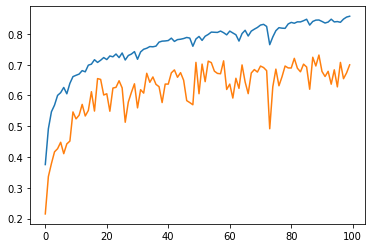

In [ ]:
history = modelPSP.fit(xTrain, yTrain, epochs=100, batch_size=32, validation_data = (xVal, yVal))
visualize(history)

#Результаты работы сети

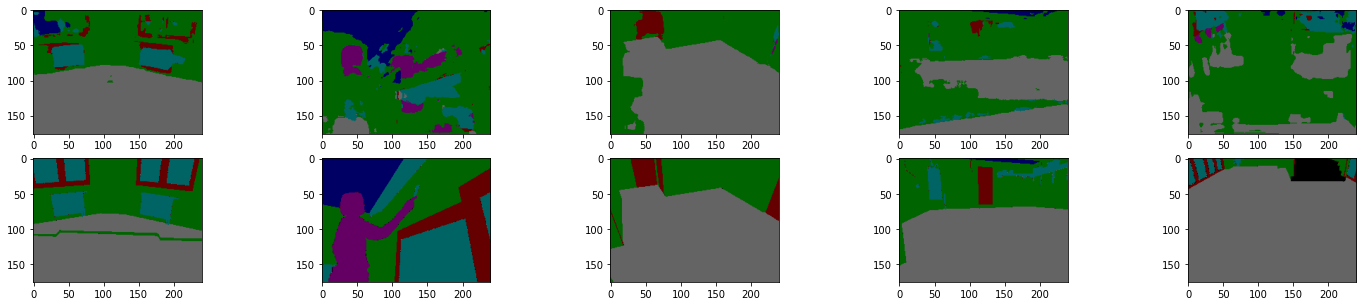

In [ ]:
processImage(modelPSP, 5, num_classes)